In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as p
import numpy as np
import flamingo_analysis as fa 
import flamingo_tangos as ft
import tangos as db

db.init_db('data-hubble-flow.db')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Sanity check
------------

The following is a basic sanity check that looks at the mass profiles at $z=1$ and $z=0$ of a halo
population that are roughly matched by their evolution (according to Fig 2 of Lucie-Smith et al),
with $\langle M \rangle ~10^{13.2}$ and $10^{13.7}$ respectively at the two epochs.

We want to sanity check that the flows at $z=0.5$ give the right order of magnitude changes in the
mass profiles.

In the first instance we look at gas+dm mass (not stars just because I didn't calculate their
profiles, so there is a very slight overall mass deficit due to this).

In [39]:
def make_sanity_check_plot(particle='total', m1=13.2, m2=13.7):
    p.figure(figsize=(12, 6))
    p.subplot(121)

    ts_start = db.get_timestep("%FIDUCIAL%/%01%")
    ts_mid = db.get_timestep("%FIDUCIAL%/%03%")
    ts_end = db.get_timestep("%FIDUCIAL%/%08%")

    match particle:
        case 'total':
            mass_calc = 'dm_mass_enclosed + gas_mass_enclosed'
            flow_calc = 'dm_mdot + gas_mdot'
        case 'gas':
            mass_calc = 'gas_mass_enclosed'
            flow_calc = 'gas_mdot'
        case 'dm':
            mass_calc = 'dm_mass_enclosed'
            flow_calc = 'dm_mdot'
        case _:
            raise ValueError(f"Unknown particle type: {particle}")

    mass_start, M200m, r200m = ts_start.calculate_all(mass_calc, 'M200m()', 'r200m')
    start_mask = (M200m>10**(m1-0.2))*(M200m<10**(m1+0.2))
    mass_start = mass_start[start_mask].mean(axis=0)
    r200m_start = r200m[start_mask].mean(axis=0)
    M200m_start = np.log10(M200m[start_mask]).mean()
    print("<M200m_start>=", M200m_start)

    mass_end, M200m, r200m = ts_end.calculate_all(mass_calc, 'M200m()', 'r200m')
    end_mask = (M200m>10**(m2-0.2))*(M200m<10**(m2+0.2))
    mass_end = mass_end[end_mask].mean(axis=0)
    r200m_end = r200m[end_mask].mean(axis=0)
    M200m_end = np.log10(M200m[end_mask]).mean()
    print("<M200m_end>=", M200m_end)


    radius_bin_edges = np.logspace(np.log10(ft.FlamingoDensityProfileAbsolute._min_rad/1000.), 
                            np.log10(ft.FlamingoDensityProfileAbsolute._max_rad/1000.), 
                            num=ft.FlamingoDensityProfileAbsolute._nbins+1)
    radius_outer_bin_edge = radius_bin_edges[1:]

    p.plot(radius_outer_bin_edge, mass_start, 'g', label=f"10^{m1} Msol at z=1")
    p.plot(radius_outer_bin_edge, mass_end, 'r', label=f"10^{m2} Msol at z=0")
    p.axvline(r200m_start/1000, color='g', linestyle='--')
    p.axvline(r200m_end/1000, color='r', linestyle='--')
    if particle == 'total':
        p.axhline(10**M200m_start, color="g", linestyle='--', label="M200m start")
        p.axhline(10**M200m_end, color="r", linestyle='--', label="M200m end")

    p.loglog()
    p.legend()

    p.ylabel("Mass enclosed")
    p.xlabel("Radius (Mpc)")
    p.title("Mass profiles")



    # assume a constant flow over time
    predicted_flow = (-mass_end+mass_start) / 7.8e9 # number of years

    flow_mid, M200m, r200m = ts_mid.calculate_all(flow_calc, 'M200m()', 'r200m')
    mid_mask = (M200m>10**m1)*(M200m<10**m2)
    flow_mid = np.nanmean(flow_mid[mid_mask], axis=0)
    r200m_mid = r200m[mid_mask].mean(axis=0)
    M200m_mid = np.log10(M200m[mid_mask]).mean()
    print("<M200m_mid>=", M200m_mid)

    radius_bin_centre = (radius_bin_edges[:-1] + radius_bin_edges[1:]) / 2
    p.subplot(122)
    p.plot(radius_bin_centre, flow_mid, 'k', label="Measured")
    p.plot(radius_outer_bin_edge, predicted_flow, 'b:', label="Predicted from profile diff")
    p.semilogx()
    p.axhline(0, color='k', linestyle='--', alpha=0.5)
    if particle == 'gas':
        p.ylim(-200, 200)
    else:
        p.ylim(-1000,1000)
    p.legend()
    p.title("Test measured vs predicted flows\n+ve flow = outflow")
    p.xlabel("Radius (Mpc)")
    p.ylabel("Mass flow rate (Msol/yr)")


<M200m_start>= 13.164144495544397
<M200m_end>= 13.665035546930495
<M200m_mid>= 13.39058330259765


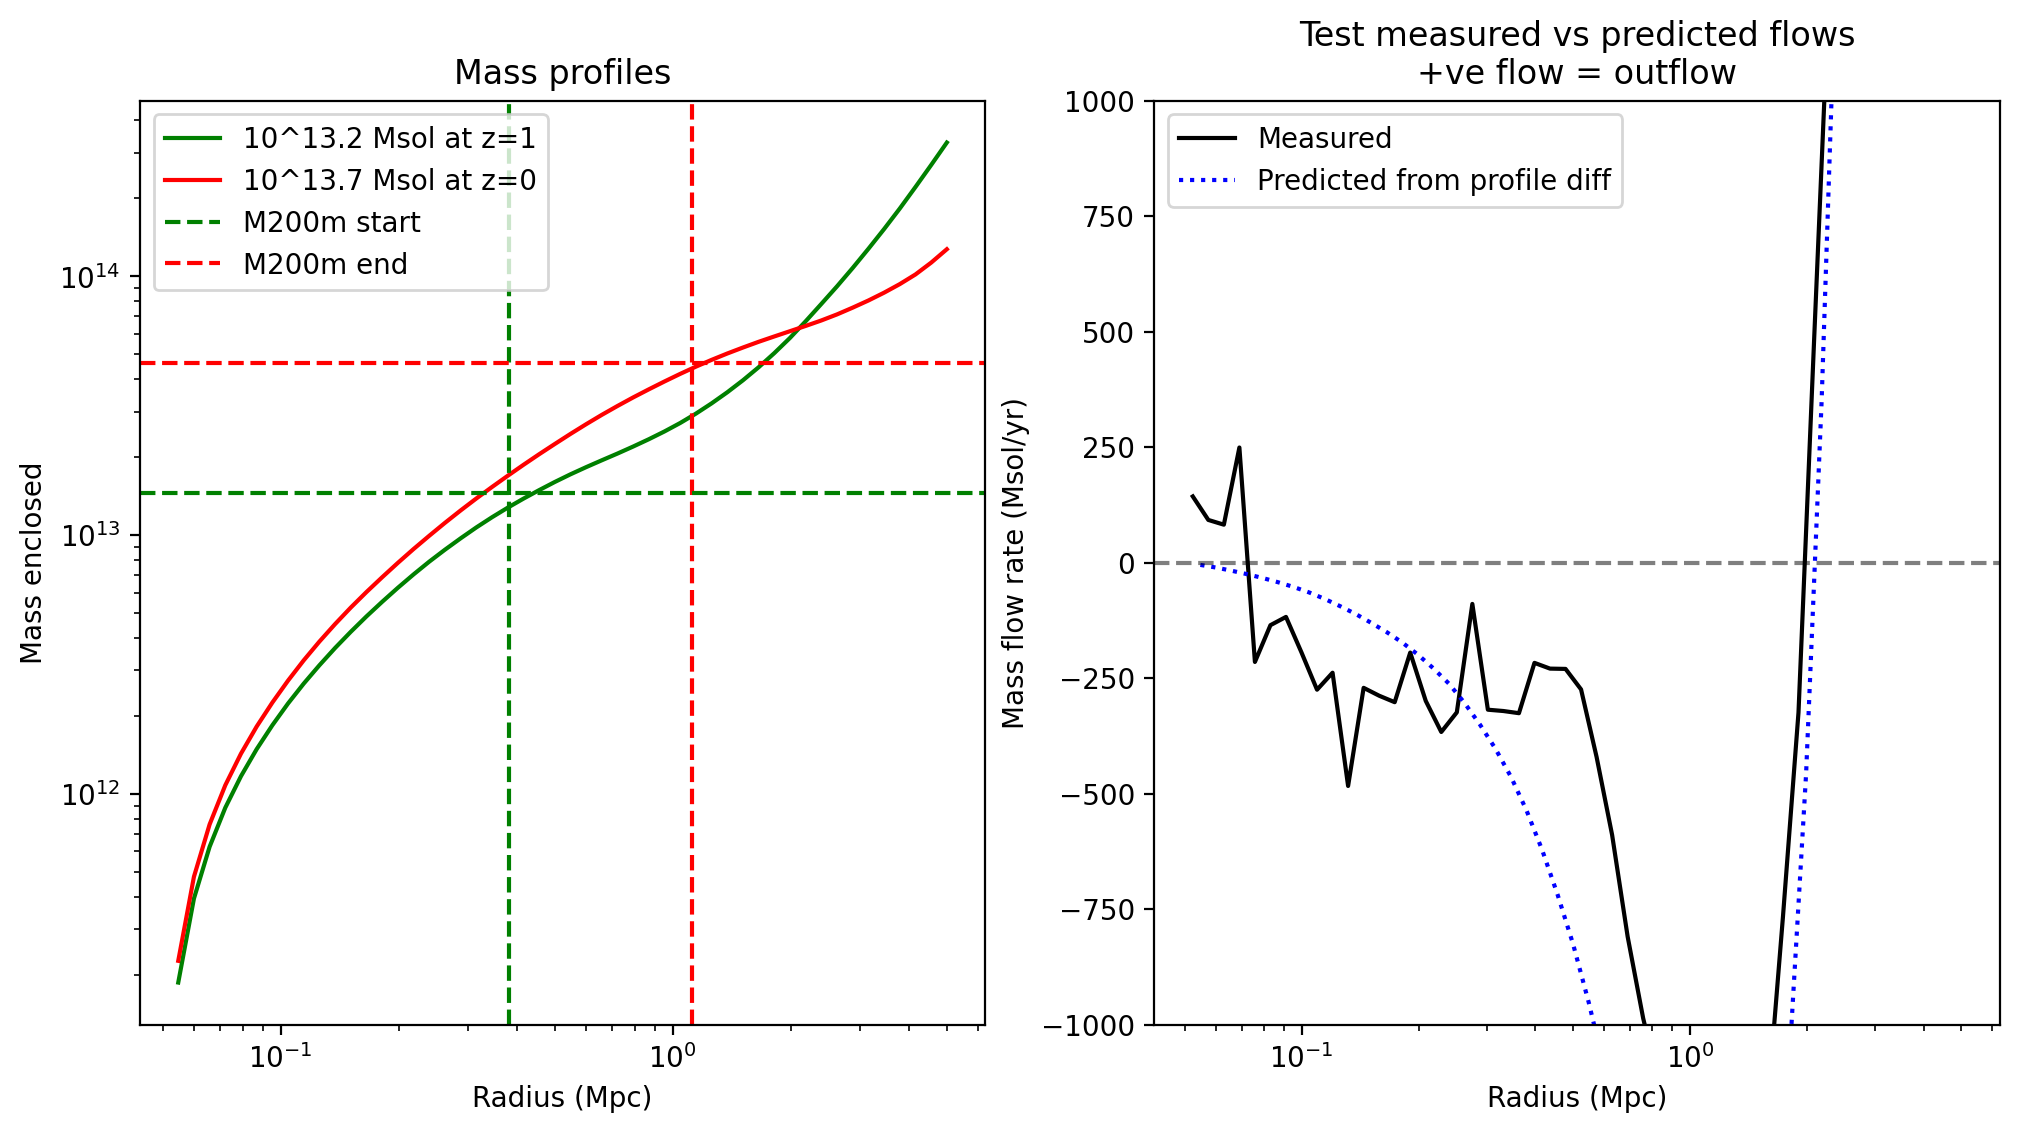

In [40]:
make_sanity_check_plot('total')

<M200m_start>= 13.164144495544397
<M200m_end>= 13.665035546930495
<M200m_mid>= 13.39058330259765


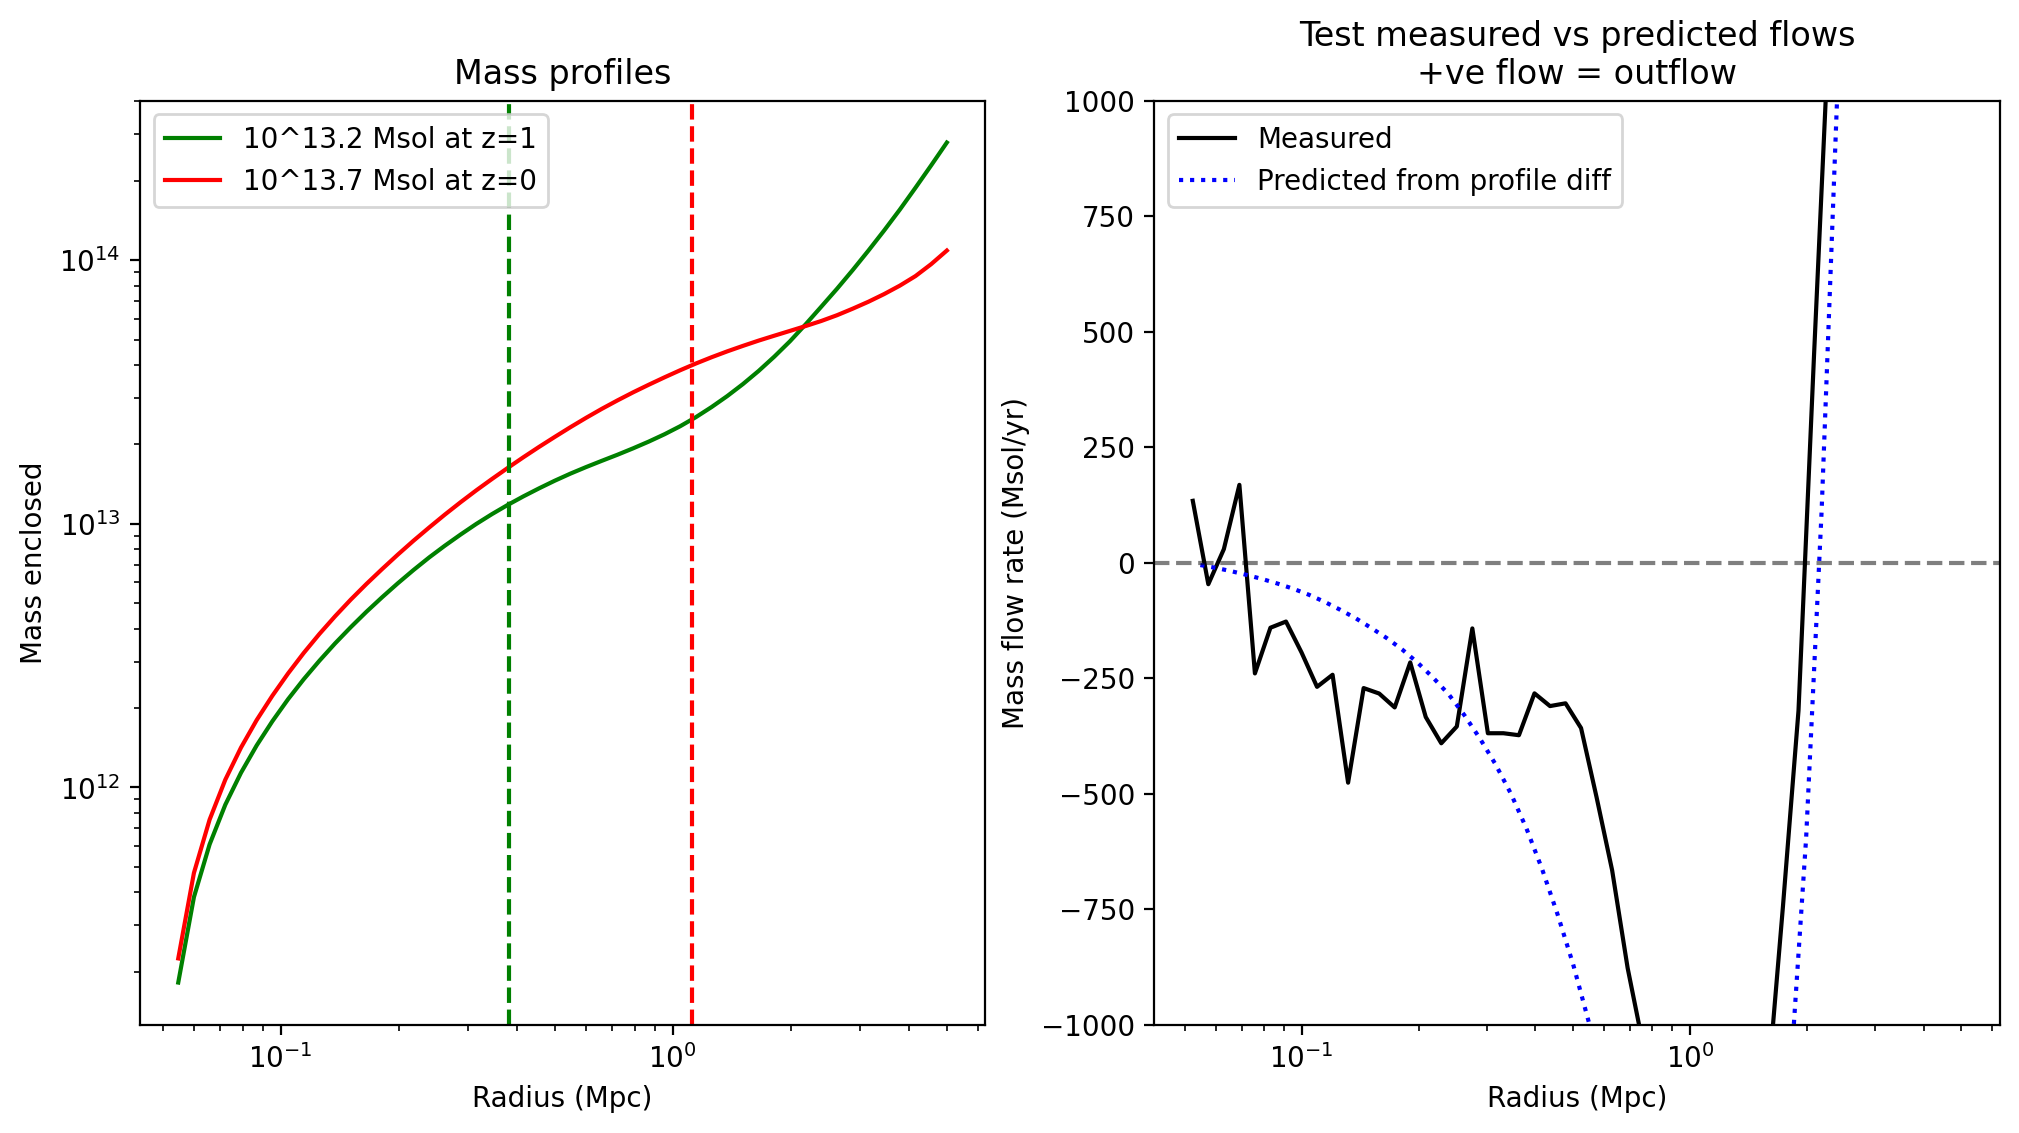

In [33]:
make_sanity_check_plot('dm')

<M200m_start>= 13.164144495544397
<M200m_end>= 13.665035546930495
<M200m_mid>= 13.39058330259765


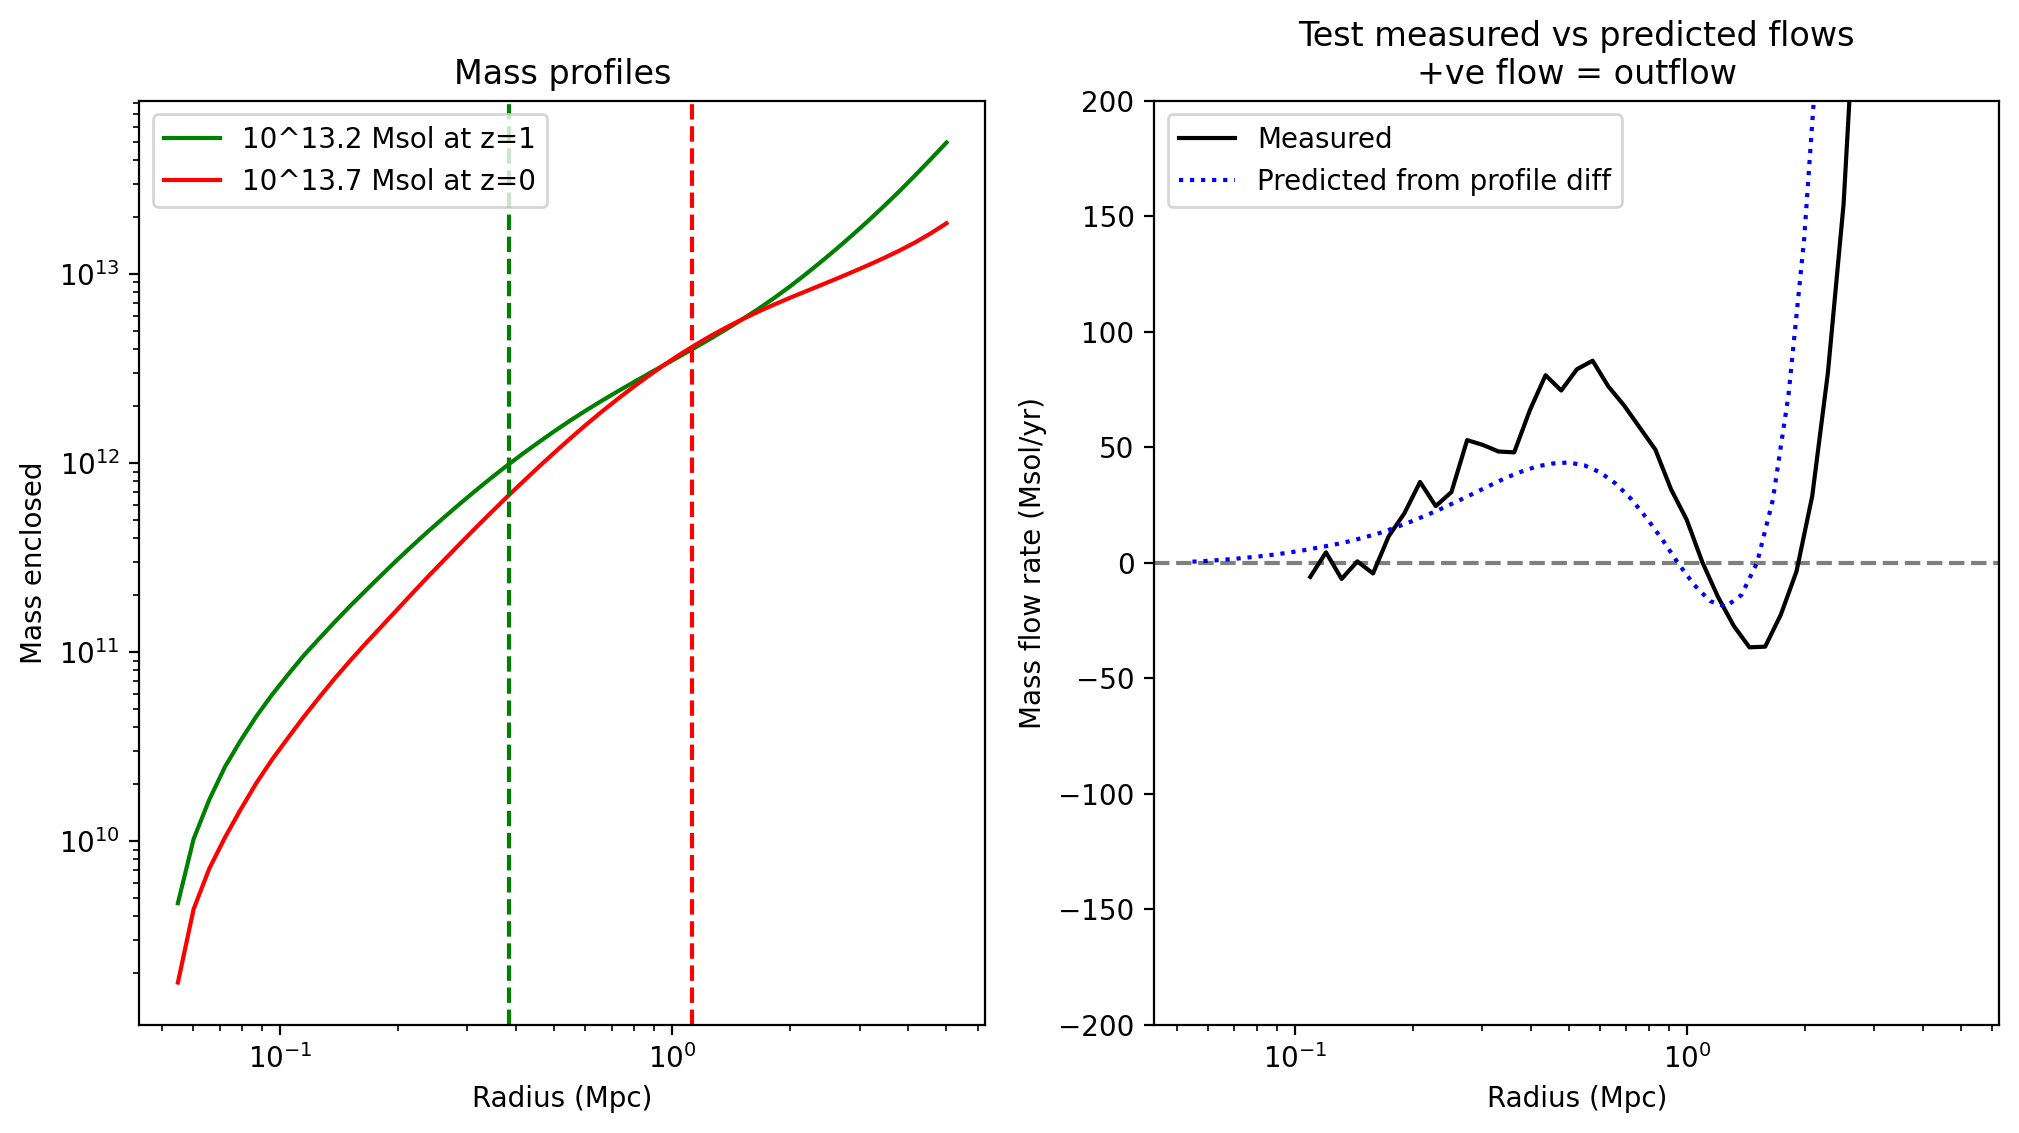

In [34]:
make_sanity_check_plot('gas')

<M200m_start>= 12.559995545075543
<M200m_end>= 12.97240025706353
<M200m_mid>= 12.73511424845751


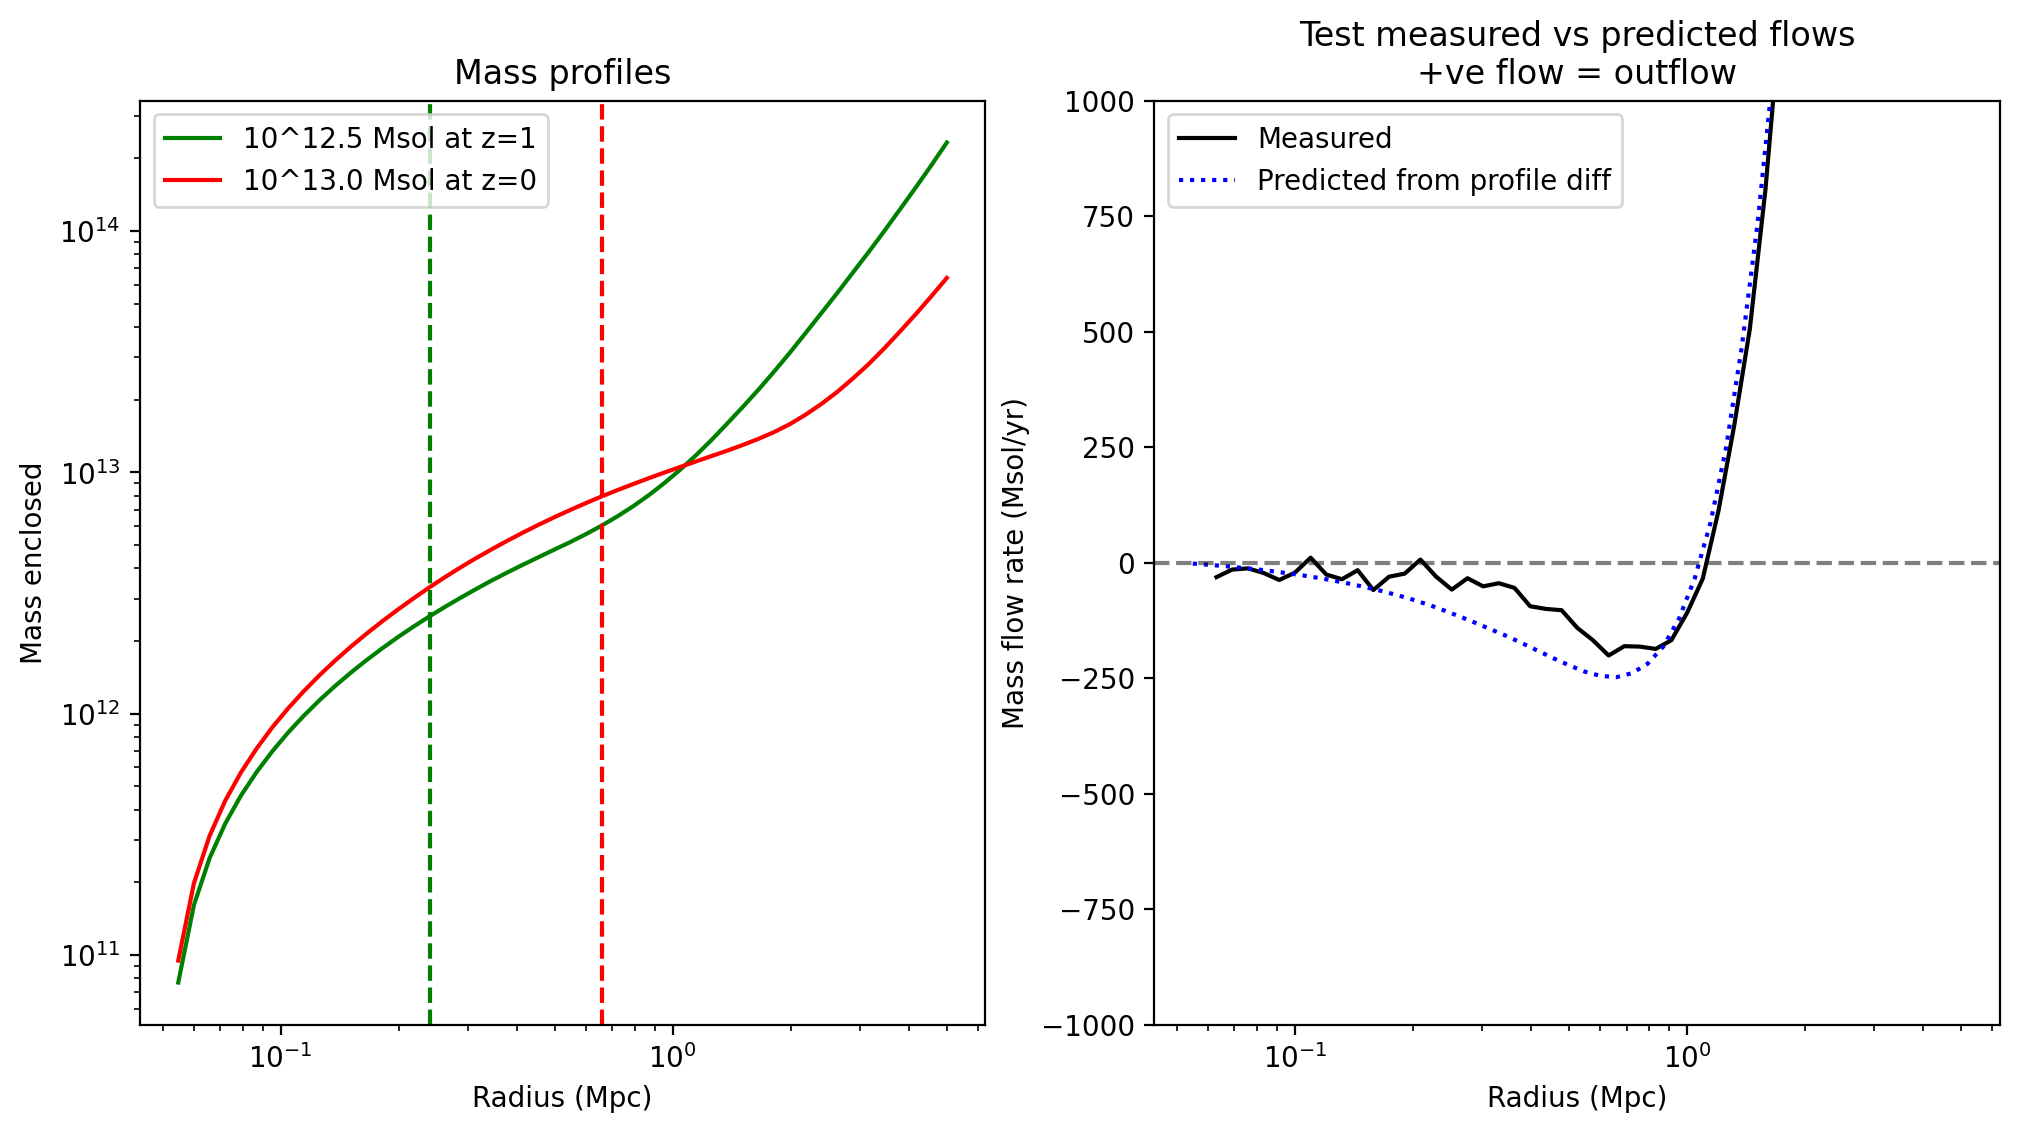

In [35]:
make_sanity_check_plot('dm', m1=12.5, m2=13.0)

<M200m_start>= 12.686524416507897
<M200m_end>= 13.164913642072062
<M200m_mid>= 12.897947503743062


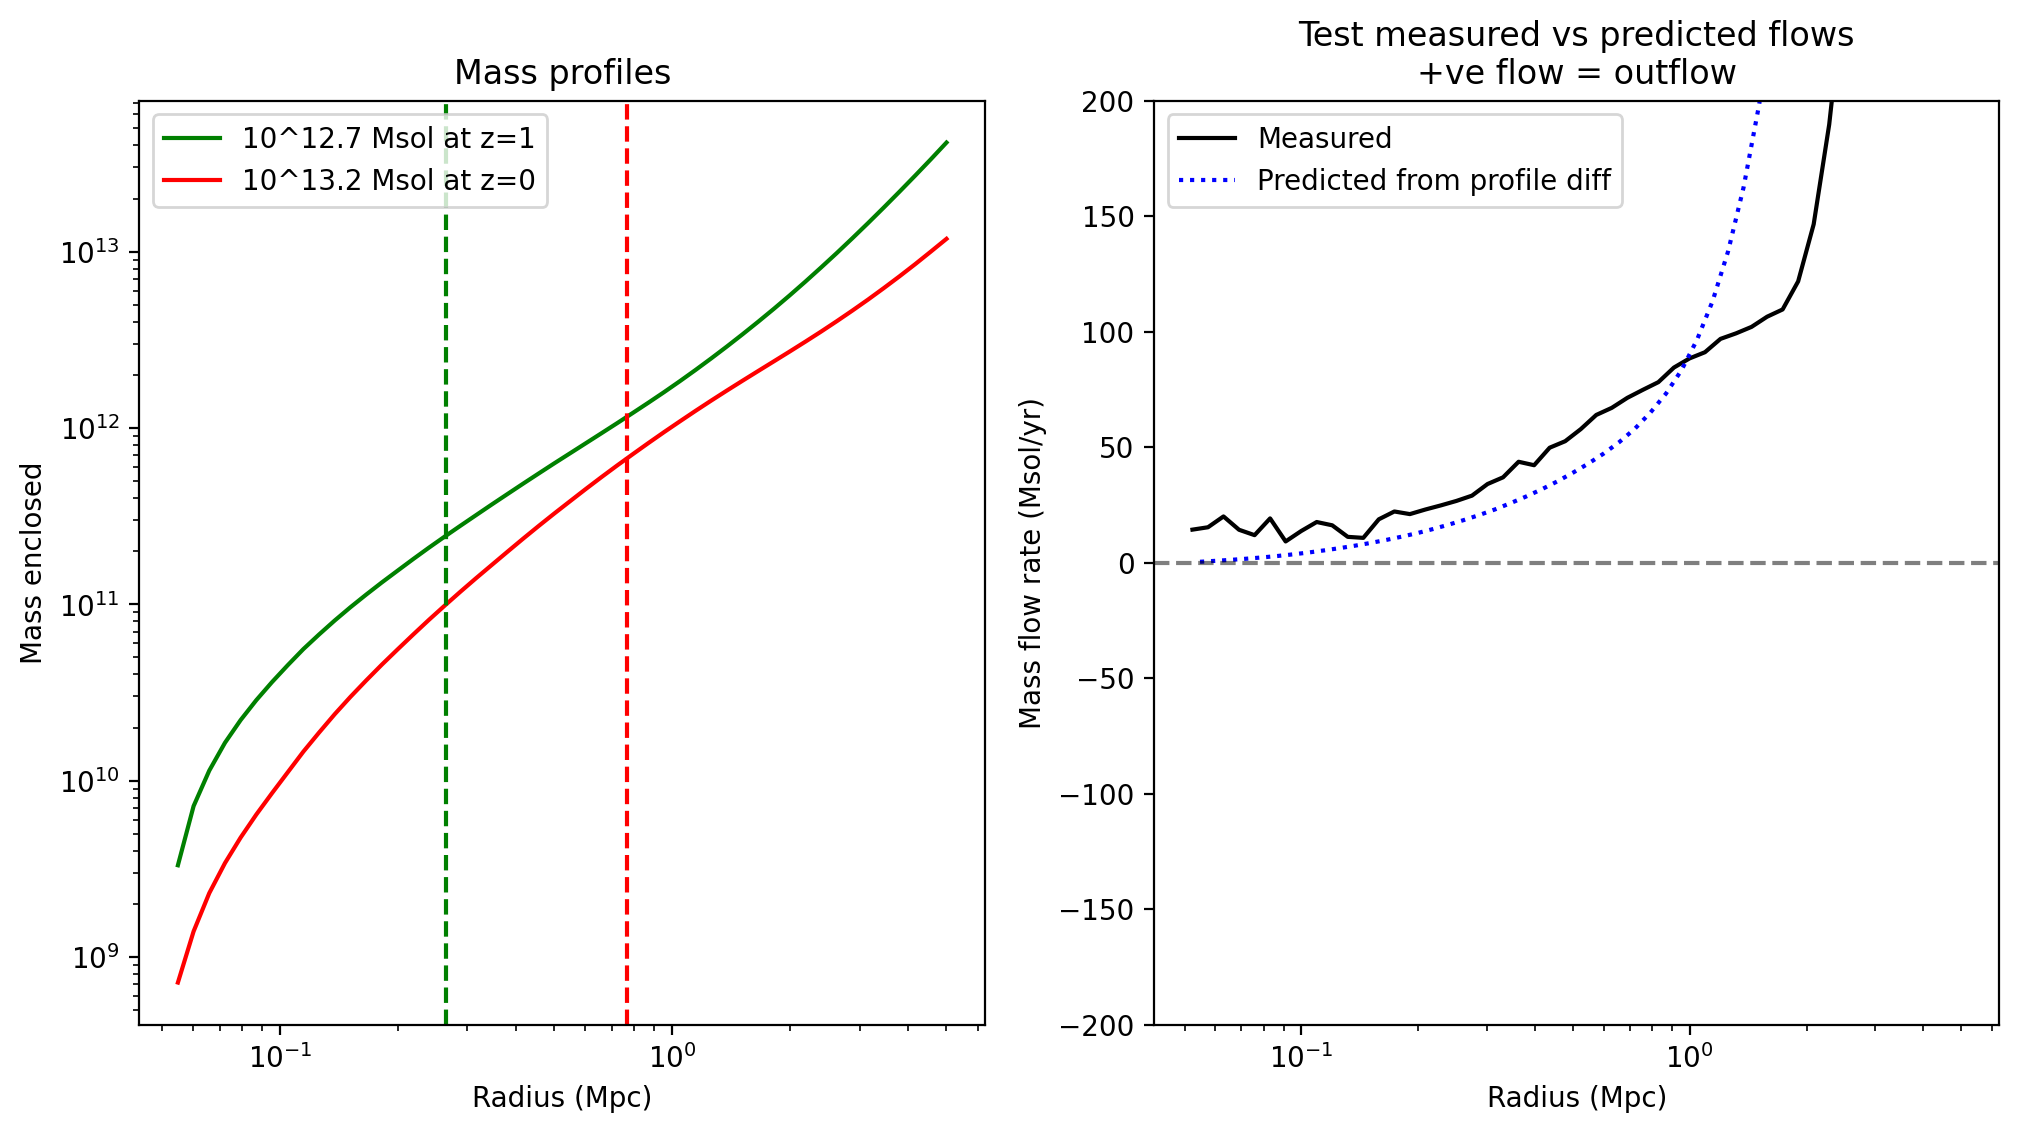

In [42]:
make_sanity_check_plot('gas', m1=12.7, m2=13.2)